<a href="https://colab.research.google.com/github/tao-c/mlops/blob/main/Copy_of_C3_W1_Lab_1_Keras_Tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Intro to Keras Tuner

Developing machine learning models is usually an iterative process. You start with an initial design then reconfigure until you get a model that can be trained efficiently in terms of time and compute resources. As you may already know, these settings that you adjust are called _hyperparameters_. These are the variables that govern the training process and the topology of an ML model. These remain constant over the training process and directly impact the performance of your ML program. 

The process of finding the optimal set of hyperparameters is called *hyperparameter tuning* or *hypertuning*, and it is an essential part of a machine learning pipeline. Without it, you might end up with a model that has unnecessary parameters and take too long to train.

Hyperparameters are of two types:
1. *Model hyperparameters* which influence model selection such as the number and width of hidden layers

2. *Algorithm hyperparameters* which influence the speed and quality of the learning algorithm such as the learning rate for Stochastic Gradient Descent (SGD) and the number of nearest neighbors for a k Nearest Neighbors (KNN) classifier.

For more complex models, the number of hyperparameters can increase dramatically and tuning them manually can be quite challenging.

In this lab, you will practice hyperparameter tuning with [Keras Tuner](https://keras-team.github.io/keras-tuner/), a package from the Keras team that automates this process. For comparison, you will first train a baseline model with pre-selected hyperparameters, then redo the process with tuned hyperparameters. Some of the examples and discussions here are taken from the [official tutorial provided by Tensorflow](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/keras_tuner.ipynb#scrollTo=sKwLOzKpFGAj) but we've expounded on a few key parts for clarity.

Let's begin!

**Note: The notebooks in this course are shared with read-only access. To be able to save your work, kindly select File > Save a Copy in Drive from the Colab menu and run the notebook from there. You will need a Gmail account to save a copy.**

## Download and prepare the dataset

Let us first load the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) into your workspace. You will use this to train a machine learning model that classifies images of clothing.

In [1]:
# Import keras
from tensorflow import keras

In [2]:
# Download the dataset and split into train and test sets
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


For preprocessing, you will normalize the pixel values to make the training converge faster.

In [4]:
# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

## Baseline Performance

As mentioned, you will first have a baseline performance using arbitrarily handpicked parameters so you can compare the results later. In the interest of time and resource limits provided by Colab, you will just build a shallow dense neural network (DNN) as shown below. This is to demonstrate the concepts without involving huge datasets and long tuning and training times. As you'll see later, even small models can take some time to tune. You can extend the concepts here when you get to build more complex models in your own projects. 

In [5]:
# Build the baseline model using the Sequential API
b_model = keras.Sequential()
b_model.add(keras.layers.Flatten(input_shape=(28, 28)))
b_model.add(keras.layers.Dense(units=512, activation='relu', name='dense_1')) # You will tune this layer later
b_model.add(keras.layers.Dropout(0.2))
b_model.add(keras.layers.Dense(10, activation='softmax'))

# Print model summary
b_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.utils import plot_model

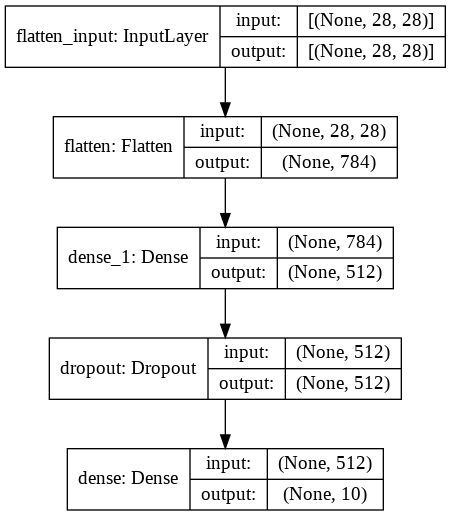

In [ ]:
plot_model(b_model, to_file='b_model.png',show_shapes=True)

As shown, we hardcoded all the hyperparameters when declaring the layers. These include the number of hidden units, activation, and dropout. You will see how you can automatically tune some of these a bit later.

Let's then setup the loss, metrics, and the optimizer. The learning rate is also a hyperparameter you can tune automatically but for now, let's set it at `0.001`.

In [6]:
# Setup the training parameters
b_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss=keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

With all settings set, you can start training the model. We've set the number of epochs to 10 but feel free to increase it if you have more time to go through the notebook. 

In [7]:
# Number of training epochs.
NUM_EPOCHS = 10

# Train the model
b_model.fit(img_train, label_train, epochs=NUM_EPOCHS, validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 7s 2ms/step - loss: 0.9804 - accuracy: 0.6802 - val_loss: 0.6475 - val_accuracy: 0.7648
Epoch 2/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6077 - accuracy: 0.7821 - val_loss: 0.5558 - val_accuracy: 0.7983
Epoch 3/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5379 - accuracy: 0.8082 - val_loss: 0.5182 - val_accuracy: 0.8129
Epoch 4/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4987 - accuracy: 0.8244 - val_loss: 0.4750 - val_accuracy: 0.8303
Epoch 5/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4712 - accuracy: 0.8341 - val_loss: 0.4538 - val_accuracy: 0.8367
Epoch 6/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4523 - accuracy: 0.8398 - val_loss: 0.4445 - val_accuracy: 0.8391
Epoch 7/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4370 - accuracy: 0.8450 - val_loss: 0.4282 - val_accuracy:

Finally, you want to see how this baseline model performs against the test set.

In [8]:
# Evaluate model on the test set
b_eval_dict = b_model.evaluate(img_test, label_test, return_dict=True)

313/313 [==============================] - 1s 2ms/step - loss: 0.4275 - accuracy: 0.8474


Let's define a helper function for displaying the results so it's easier to compare later.

In [9]:
b_eval_dict

{'accuracy': 0.8474000096321106, 'loss': 0.42753124237060547}

In [10]:
# Define helper function
def print_results(model, model_name, eval_dict):
  '''
  Prints the values of the hyparameters to tune, and the results of model evaluation

  Args:
    model (Model) - Keras model to evaluate
    model_name (string) - arbitrary string to be used in identifying the model
    eval_dict (dict) -  results of model.evaluate
  '''
  print(f'\n{model_name}:')

  print(f'number of units in 1st Dense layer: {model.get_layer("dense_1").units}')
  print(f'learning rate for the optimizer: {model.optimizer.lr.numpy()}')

  for key,value in eval_dict.items():
    print(f'{key}: {value}')

# Print results for baseline model
print_results(b_model, 'BASELINE MODEL', b_eval_dict)


BASELINE MODEL:
number of units in 1st Dense layer: 512
learning rate for the optimizer: 0.0010000000474974513
loss: 0.42753124237060547
accuracy: 0.8474000096321106


That's it for getting the results for a single set of hyperparameters. As you can see, this process can be tedious if you want to try different sets of parameters. For example, will your model improve if you use `learning_rate=0.00001` and `units=128`? What if `0.001` paired with `256`? The process will be even more difficult if you decide to also tune the dropout and try out other activation functions as well. Keras Tuner solves this problem by having an API to automatically search for the optimal set. You will just need to set it up once then wait for the results. You will see how this is done in the next sections.

## Keras Tuner

To perform hypertuning with Keras Tuner, you will need to:

* Define the model
* Select which hyperparameters to tune
* Define its search space
* Define the search strategy

### Install and import packages

You will start by installing and importing the required packages.

In [11]:
# Install Keras Tuner
!pip install -q -U keras-tuner

     |████████████████████████████████| 96 kB 2.1 MB/s 


In [12]:
# Import required packages
import tensorflow as tf
import kerastuner as kt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  This is separate from the ipykernel package so we can avoid doing imports until


### Define the model

The model you set up for hypertuning is called a *hypermodel*. When you build this model, you define the hyperparameter search space in addition to the model architecture. 

You can define a hypermodel through two approaches:

* By using a model builder function
* By [subclassing the `HyperModel` class](https://keras-team.github.io/keras-tuner/#you-can-use-a-hypermodel-subclass-instead-of-a-model-building-function) of the Keras Tuner API


In this lab, you will take the first approach: you will use a model builder function to define the image classification model. This function returns a compiled model and uses hyperparameters you define inline to hypertune the model. 

The function below basically builds the same model you used earlier. The difference is there are two hyperparameters that are setup for tuning:

* the number of hidden units of the first Dense layer
* the learning rate of the Adam optimizer

You will see that this is done with a HyperParameters object which configures the hyperparameter you'd like to tune. For this exercise, you will: 

* use its `Int()` method to define the search space for the Dense units. This allows you to set a minimum and maximum value, as well as the step size when incrementing between these values. 

* use its `Choice()` method for the learning rate. This allows you to define discrete values to include in the search space when hypertuning.

You can view all available methods and its sample usage in the [official documentation](https://keras-team.github.io/keras-tuner/documentation/hyperparameters/#hyperparameters).

In [13]:
def model_builder(hp):
  '''
  Builds the model and sets up the hyperparameters to tune.

  Args:
    hp - Keras tuner object

  Returns:
    model with hyperparameters to tune
  '''

  # Initialize the Sequential API and start stacking the layers
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu', name='dense_1'))

  # Add next layers
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(10, activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

  return model

## Instantiate the Tuner and perform hypertuning

Now that you have the model builder, you can then define how the tuner can find the optimal set of hyperparameters, also called the search strategy. Keras Tuner has [four tuners](https://keras-team.github.io/keras-tuner/documentation/tuners/) available with built-in strategies - `RandomSearch`, `Hyperband`, `BayesianOptimization`, and `Sklearn`. 

In this tutorial, you will use the Hyperband tuner. Hyperband is an algorithm specifically developed for hyperparameter optimization. It uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model. This is done using a sports championship style bracket wherein the algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round. You can read about the intuition behind the algorithm in section 3 of [this paper](https://arxiv.org/pdf/1603.06560.pdf).

Hyperband determines the number of models to train in a bracket by computing 1 + log<sub>`factor`</sub>(`max_epochs`) and rounding it up to the nearest integer. You will see these parameters (i.e. `factor` and `max_epochs` passed into the initializer below). In addition, you will also need to define the following to instantiate the Hyperband tuner:

* the hypermodel (built by your model builder function)
* the `objective` to optimize (e.g. validation accuracy)
* a `directory` to save logs and checkpoints for every trial (model configuration) run during the hyperparameter search. If you re-run the hyperparameter search, the Keras Tuner uses the existing state from these logs to resume the search. To disable this behavior, pass an additional `overwrite=True` argument while instantiating the tuner.
* the `project_name` to differentiate with other runs. This will be used as a subdirectory name under the `directory`.

You can refer to the [documentation](https://keras.io/api/keras_tuner/tuners/hyperband/) for other arguments you can pass in.

In [14]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='kt_dir',
                     project_name='kt_hyperband')

Let's see a summary of the hyperparameters that you will tune:

In [15]:
# Display hypertuning settings
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


You can pass in a callback to stop training early when a metric is not improving. Below, we define an [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback to monitor the validation loss and stop training if it's not improving after 5 epochs.

In [16]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

You will now run the hyperparameter search. The arguments for the search method are the same as those used for `tf.keras.model.fit` in addition to the callback above. This will take around 10 minutes to run.

In [17]:
# Perform hypertuning
tuner.search(img_train, label_train, epochs=NUM_EPOCHS, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 00m 41s]
val_accuracy: 0.8520833253860474

Best val_accuracy So Far: 0.8801666498184204
Total elapsed time: 00h 09m 19s
INFO:tensorflow:Oracle triggered exit


You can get the top performing model with the [get_best_hyperparameters()](https://keras-team.github.io/keras-tuner/documentation/tuners/#get_best_hyperparameters-method)  method.

In [18]:
# Get the optimal hyperparameters from the results
best_hps=tuner.get_best_hyperparameters()[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 288 and the optimal learning rate for the optimizer
is 0.01.



## Build and train the model

Now that you have the best set of hyperparameters, you can rebuild the hypermodel with these values and retrain it.

In [19]:
# Build the model with the optimal hyperparameters
h_model = tuner.hypermodel.build(best_hps)
h_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 288)               226080    
_________________________________________________________________
dropout (Dropout)            (None, 288)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                2890      
Total params: 228,970
Trainable params: 228,970
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Train the hypertuned model
h_model.fit(img_train, label_train, epochs=NUM_EPOCHS, validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6391 - accuracy: 0.7666 - val_loss: 0.4586 - val_accuracy: 0.8282
Epoch 2/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.4550 - accuracy: 0.8338 - val_loss: 0.4194 - val_accuracy: 0.8447
Epoch 3/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4134 - accuracy: 0.8471 - val_loss: 0.3906 - val_accuracy: 0.8536
Epoch 4/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3871 - accuracy: 0.8590 - val_loss: 0.3732 - val_accuracy: 0.8656
Epoch 5/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3712 - accuracy: 0.8634 - val_loss: 0.3570 - val_accuracy: 0.8724
Epoch 6/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3577 - accuracy: 0.8673 - val_loss: 0.3764 - val_accuracy: 0.8618
Epoch 7/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3464 - accuracy: 0.8712 - val_loss: 0.3508 - val_accuracy:

You will then get its performance against the test set.

In [21]:
# Evaluate the hypertuned model against the test set
h_eval_dict = h_model.evaluate(img_test, label_test, return_dict=True)

313/313 [==============================] - 1s 2ms/step - loss: 0.3582 - accuracy: 0.8717


We can compare the results we got with the baseline model we used at the start of the notebook. Results may vary but you will usually get a model that has less units in the dense layer, while having comparable loss and accuracy. This indicates that you reduced the model size and saved compute resources while still having more or less the same accuracy.

In [22]:
# Print results of the baseline and hypertuned model
print_results(b_model, 'BASELINE MODEL', b_eval_dict)
print_results(h_model, 'HYPERTUNED MODEL', h_eval_dict)


BASELINE MODEL:
number of units in 1st Dense layer: 512
learning rate for the optimizer: 0.0010000000474974513
loss: 0.42753124237060547
accuracy: 0.8474000096321106

HYPERTUNED MODEL:
number of units in 1st Dense layer: 288
learning rate for the optimizer: 0.009999999776482582
loss: 0.3581571578979492
accuracy: 0.8716999888420105


## Bonus Challenges (optional)

If you want to keep practicing with Keras Tuner in this notebook, you can do a factory reset (`Runtime > Factory reset runtime`) and take on any of the following:

- hypertune the dropout layer with `hp.Float()` or `hp.Choice()`
- hypertune the activation function of the 1st dense layer with `hp.Choice()`
- determine the optimal number of Dense layers you can add to improve the model. You can use the code [here](https://keras.io/guides/keras_tuner/getting_started/#the-search-space-may-contain-conditional-hyperparameters) as reference.
- explore pre-defined `HyperModel` classes - [HyperXception and HyperResNet](https://keras-team.github.io/keras-tuner/documentation/hypermodels/#hyperresnet-class) for computer vision applications.

## Wrap Up

In this tutorial, you used Keras Tuner to conveniently tune hyperparameters. You defined which ones to tune, the search space, and search strategy to arrive at the optimal set of hyperparameters. These concepts will again be discussed in the next sections but in the context of AutoML, a package that automates the entire machine learning pipeline. On to the next!
